# ANALYSIS:

In [213]:
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistical tests:
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [214]:
clean_data = pd.read_csv('project-data/clean_cahoots_envs_data.csv')

clean_data.head(3)

,Date,IncidentCategory,tempmin,tempmax,precip,snow,conditions,AQI,AQI_Category,daily calls,extreme heat,extreme cold,snow event,ice event,AQI hazard
0,2016-01-01,Medical Assistance,26.1,40.0,0.0,0.0,Clear,108,Unhealthy for Sensitive Groups,641,0,1,0,0,0
1,2016-01-01,Medical Assistance,26.1,40.0,0.0,0.0,Clear,108,Unhealthy for Sensitive Groups,641,0,1,0,0,0
2,2016-01-01,Medical Assistance,26.1,40.0,0.0,0.0,Clear,108,Unhealthy for Sensitive Groups,641,0,1,0,0,0


In [215]:
# MAKE SURE Date column in clean_data is DATETIME
if not pd.api.types.is_datetime64_any_dtype(clean_data['Date']):
    clean_data['Date'] = pd.to_datetime(clean_data['Date'])

# DAILY SUMMARY grouped dataframe
daily = clean_data.groupby('Date').agg({'daily calls': 'first', 'extreme heat': 'max', 'extreme cold': 'min', 
                                      'snow': 'max', 'precip': 'max', 
                                      'snow event': 'max', 'ice event': 'max', 'AQI hazard': 'max',
                                      'tempmax': 'mean', 'tempmin': 'mean', 'AQI': 'mean'}).reset_index()

daily.head(2)

,Date,daily calls,extreme heat,extreme cold,snow,precip,snow event,ice event,AQI hazard,tempmax,tempmin,AQI
0,2016-01-01,641,0,1,0.0,0.0,0,0,0,40.0,26.1,108.0
1,2016-01-02,466,0,1,0.0,0.0,0,0,0,36.1,20.9,83.0


## 1. CALL VOLUME Hypothesis testing: Is there a statistically significant difference between distributions of daily call volume during extreme vs. non extreme days for each type of environmental event?
### Using the **Mann Whitney U test**, because it:
- doesn't assume normal distributions
- works well with uneven sample sizes
- tests whether one group tends to have higher values than the other


---

Analyzing: extreme heat

Normal days: 1779
extreme heat days: 91


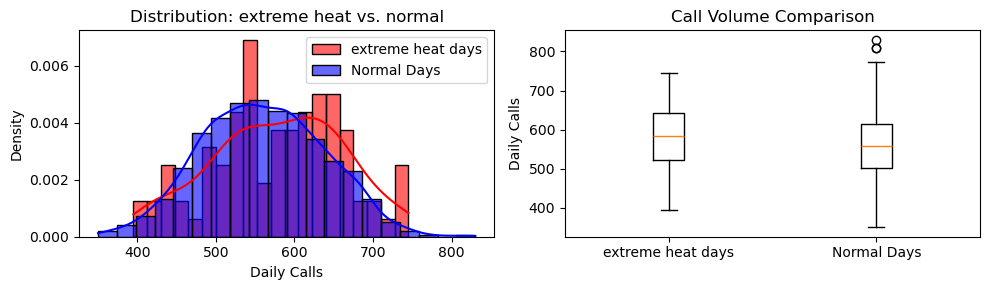

P-value: 0.023511286427935603
Mean calls on Extreme Heat days (n=91): 578.4
Mean calls on normal days (n=1779): 559.8
Average difference: 18.6 calls (3.3%)

---

Analyzing: extreme cold

Normal days: 1766
extreme cold days: 104


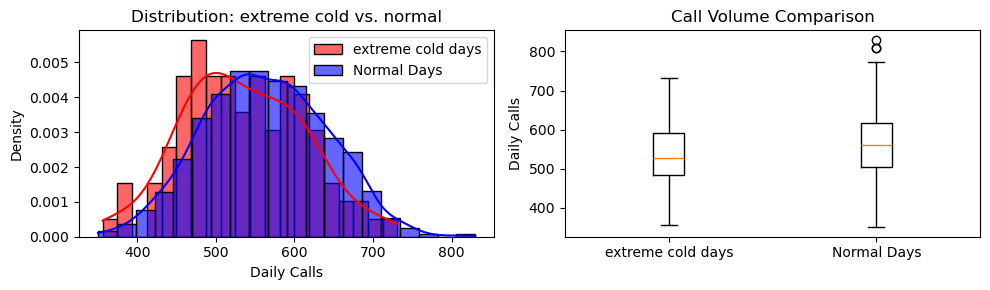

P-value: 0.0005818130547222265
Mean calls on Extreme Cold days (n=104): 534.8
Mean calls on normal days (n=1766): 562.2
Average difference: -27.5 calls (-4.9%)

---

Analyzing: snow event

Normal days: 1840
snow event days: 30


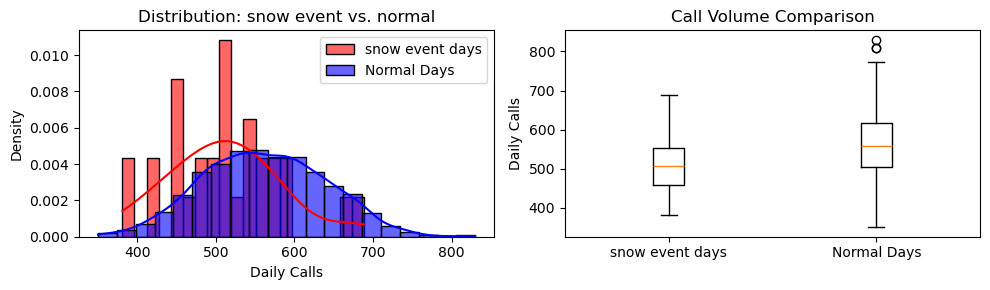

P-value: 0.00042769391839203607
Mean calls on Snow Event days (n=30): 511.0
Mean calls on normal days (n=1840): 561.5
Average difference: -50.6 calls (-9.0%)

---

Analyzing: ice event

Normal days: 1812
ice event days: 58


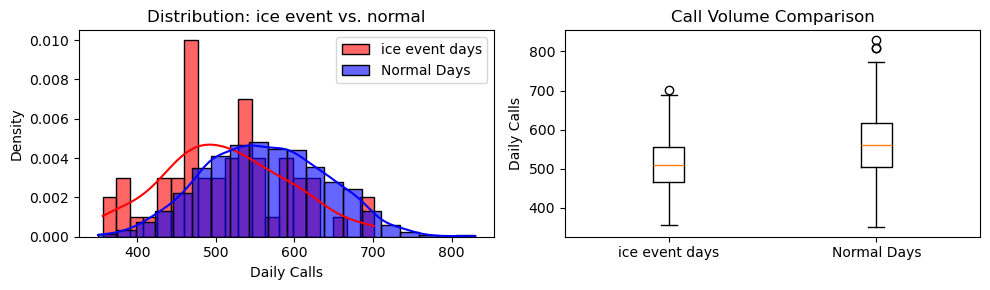

P-value: 4.898139744034482e-06
Mean calls on Ice Event days (n=58): 511.9
Mean calls on normal days (n=1812): 562.3
Average difference: -50.4 calls (-9.0%)

---

Analyzing: AQI hazard

Normal days: 1854
AQI hazard days: 16


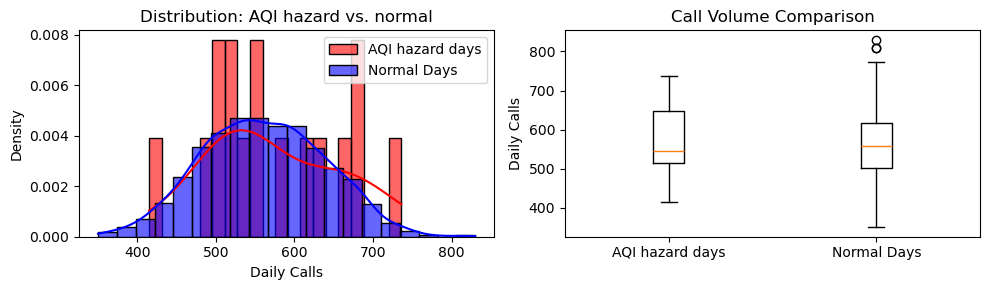

P-value: 0.6491147964667375
Mean calls on Aqi Hazard days (n=16): 572.9
Mean calls on normal days (n=1854): 560.6
Average difference: 12.3 calls (2.2%)


In [217]:
# function to do mann whitney u test for each environmental variable
def analyze_condition(daily_df, env_col):
    """
    Analyze call volume on days with vs. without an extreme environmental condition
    """
    
    print(f"\n---\n\nAnalyzing: {env_col}\n")
    
    # Split data
    normal = daily_df[daily_df[env_col] == 0].sort_values('Date')
    extreme = daily_df[daily_df[env_col] == 1].sort_values('Date')
    # print group sizes
    print(f"Normal days: {len(normal)}")
    print(f"{env_col} days: {len(extreme)}")

    # two side by side plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Histogram of the data groups:
    # plot DENSITY because the two groups have different sample sizes
    # (to visualize the shape of the distributions, not the size of the samples)
    sns.histplot(extreme['daily calls'], stat='density', kde=True, color='red', label=f'{env_col} days', bins=20, alpha=0.6, ax=axes[0])
    sns.histplot(normal['daily calls'], stat='density', kde=True, color='blue', label='Normal Days', bins=20, alpha=0.6, ax=axes[0])
    axes[0].set_xlabel('Daily Calls')
    axes[0].set_ylabel('Density')
    axes[0].set_title(f'Distribution: {env_col} vs. normal')
    axes[0].legend()

    # Boxplot
    data = [extreme['daily calls'], normal['daily calls']]
    axes[1].boxplot(data, labels=[f'{env_col} days', 'Normal Days'])
    axes[1].set_ylabel('Daily Calls')
    axes[1].set_title(f'Call Volume Comparison')

    plt.tight_layout()
    plt.show()

    
    # Mann-Whitney U Test
    statistic, p_value = mannwhitneyu(extreme['daily calls'], normal['daily calls'])
    print("P-value:", p_value)
    
    # What percent change is actually happening? (difference in MEANS)
    # Because a statistically significant result with a tiny practical difference isn't very meaningful for CAHOOTS operations
    mean_extreme = extreme['daily calls'].mean()
    mean_normal = normal['daily calls'].mean()
    pct_change = (mean_extreme / mean_normal - 1) * 100
    print(f"Mean calls on {env_col.title()} days (n={len(extreme)}): {mean_extreme:.1f}")
    print(f"Mean calls on normal days (n={len(normal)}): {mean_normal:.1f}")
    print(f"Average difference: {mean_extreme - mean_normal:.1f} calls ({pct_change:.1f}%)")



# Run mann-whitney u test on each environmental variable:
envs = ['extreme heat', 'extreme cold', 'snow event', 'ice event', 'AQI hazard']
for variable in envs:
    analyze_condition(daily, variable)

### 1.2 RESULTS:
- Small p-values indicate a statistically significant difference in call volume during every extreme environmental event (versus on normal days)
- Call volume doesn't always just _increase_ (sometimes it decreases!), the distributions are just different.
- This statistically significant difference in volume also doesn't give us much information about how crisis _needs_ / the _types of calls_ differ during these events.

## 2. CATEGORICAL Call Type Analysis: Is the proportion of certain call categories significantly higher during specific environmental extremes? (test if there is an association, and then whether certain proportions change significantly).

### 2.1 Using the **Chi Squared Test of Independence** to evaluate association, because it:
- compares whether distributions differ between two independent, **categorical** groups
- The Chi-square test of independence is a statistical hypothesis test used to determine whether two categorical or nominal variables are likely to be related or not.
- Chi squared test assumes independent observations, categorical data, and large enough sample sizes / intersections between categories (>5).
- In this case, the Chi squared test is testing this null hypothesis "There is no association between the environmental condition (i.e. extreme heat) and the distribution of call categories"

In [221]:
def run_chi_square_test(data, condition_col, label):
    '''
    chi squared test to test relationship between categorical variables' distributions, for each environmental variable

    data: data table
    condition_col: environmental conditions like extreme heat, etc.
    label: string for printing results

    Returns:
    observed counts of calltypes (contingency table)
    The expected counts under the assumption of independence
    '''
    # Create contingency table: counts of each call type on extreme vs. non-extreme days
    contingency = pd.crosstab(data['IncidentCategory'], data[condition_col])

    # do Chi2 test of independence
    # print table shape and min expected count check (chi2 assumptions)
    chi2, p, dof, expected = chi2_contingency(contingency)
    expected_df = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)
    # Check assumptions
    min_expected = expected_df.min().min()
    too_small = (expected_df < 5).sum().sum()

    # print results
    print(f"\nChi-Square Test: {label}")
    print(f"Chi2 stat: {chi2}, p-value: {p}, degrees of freedom: {dof}")

    return contingency, expected_df


# Run chi2 test for each environmental event / extreme
for cond, name in zip(['extreme heat', 'extreme cold', 'snow event', 'ice event', 'AQI hazard'],
                      ['Extreme Heat', 'Extreme Cold', 'Snow', 'Ice', 'Poor Air Quality']):
    run_chi_square_test(clean_data, cond, name)


Chi-Square Test: Extreme Heat
Chi2 stat: 194.73924764200336, p-value: 1.4913185323049725e-38, degrees of freedom: 7

Chi-Square Test: Extreme Cold
Chi2 stat: 339.3990948035211, p-value: 2.28799829836939e-69, degrees of freedom: 7

Chi-Square Test: Snow
Chi2 stat: 150.60170417248895, p-value: 3.03489152188669e-29, degrees of freedom: 7

Chi-Square Test: Ice
Chi2 stat: 160.49184108954324, p-value: 2.5274993958240006e-31, degrees of freedom: 7

Chi-Square Test: Poor Air Quality
Chi2 stat: 82.94800604610262, p-value: 3.4455277814814408e-15, degrees of freedom: 7


#### Extremely small p-values indicate that the distribution of call categories changes **significantly** during environmental extremes compared to normal days.

### 2.2 Follow-up visualizations to compare the proportions of specific call categories that increased/decreased during extreme events:

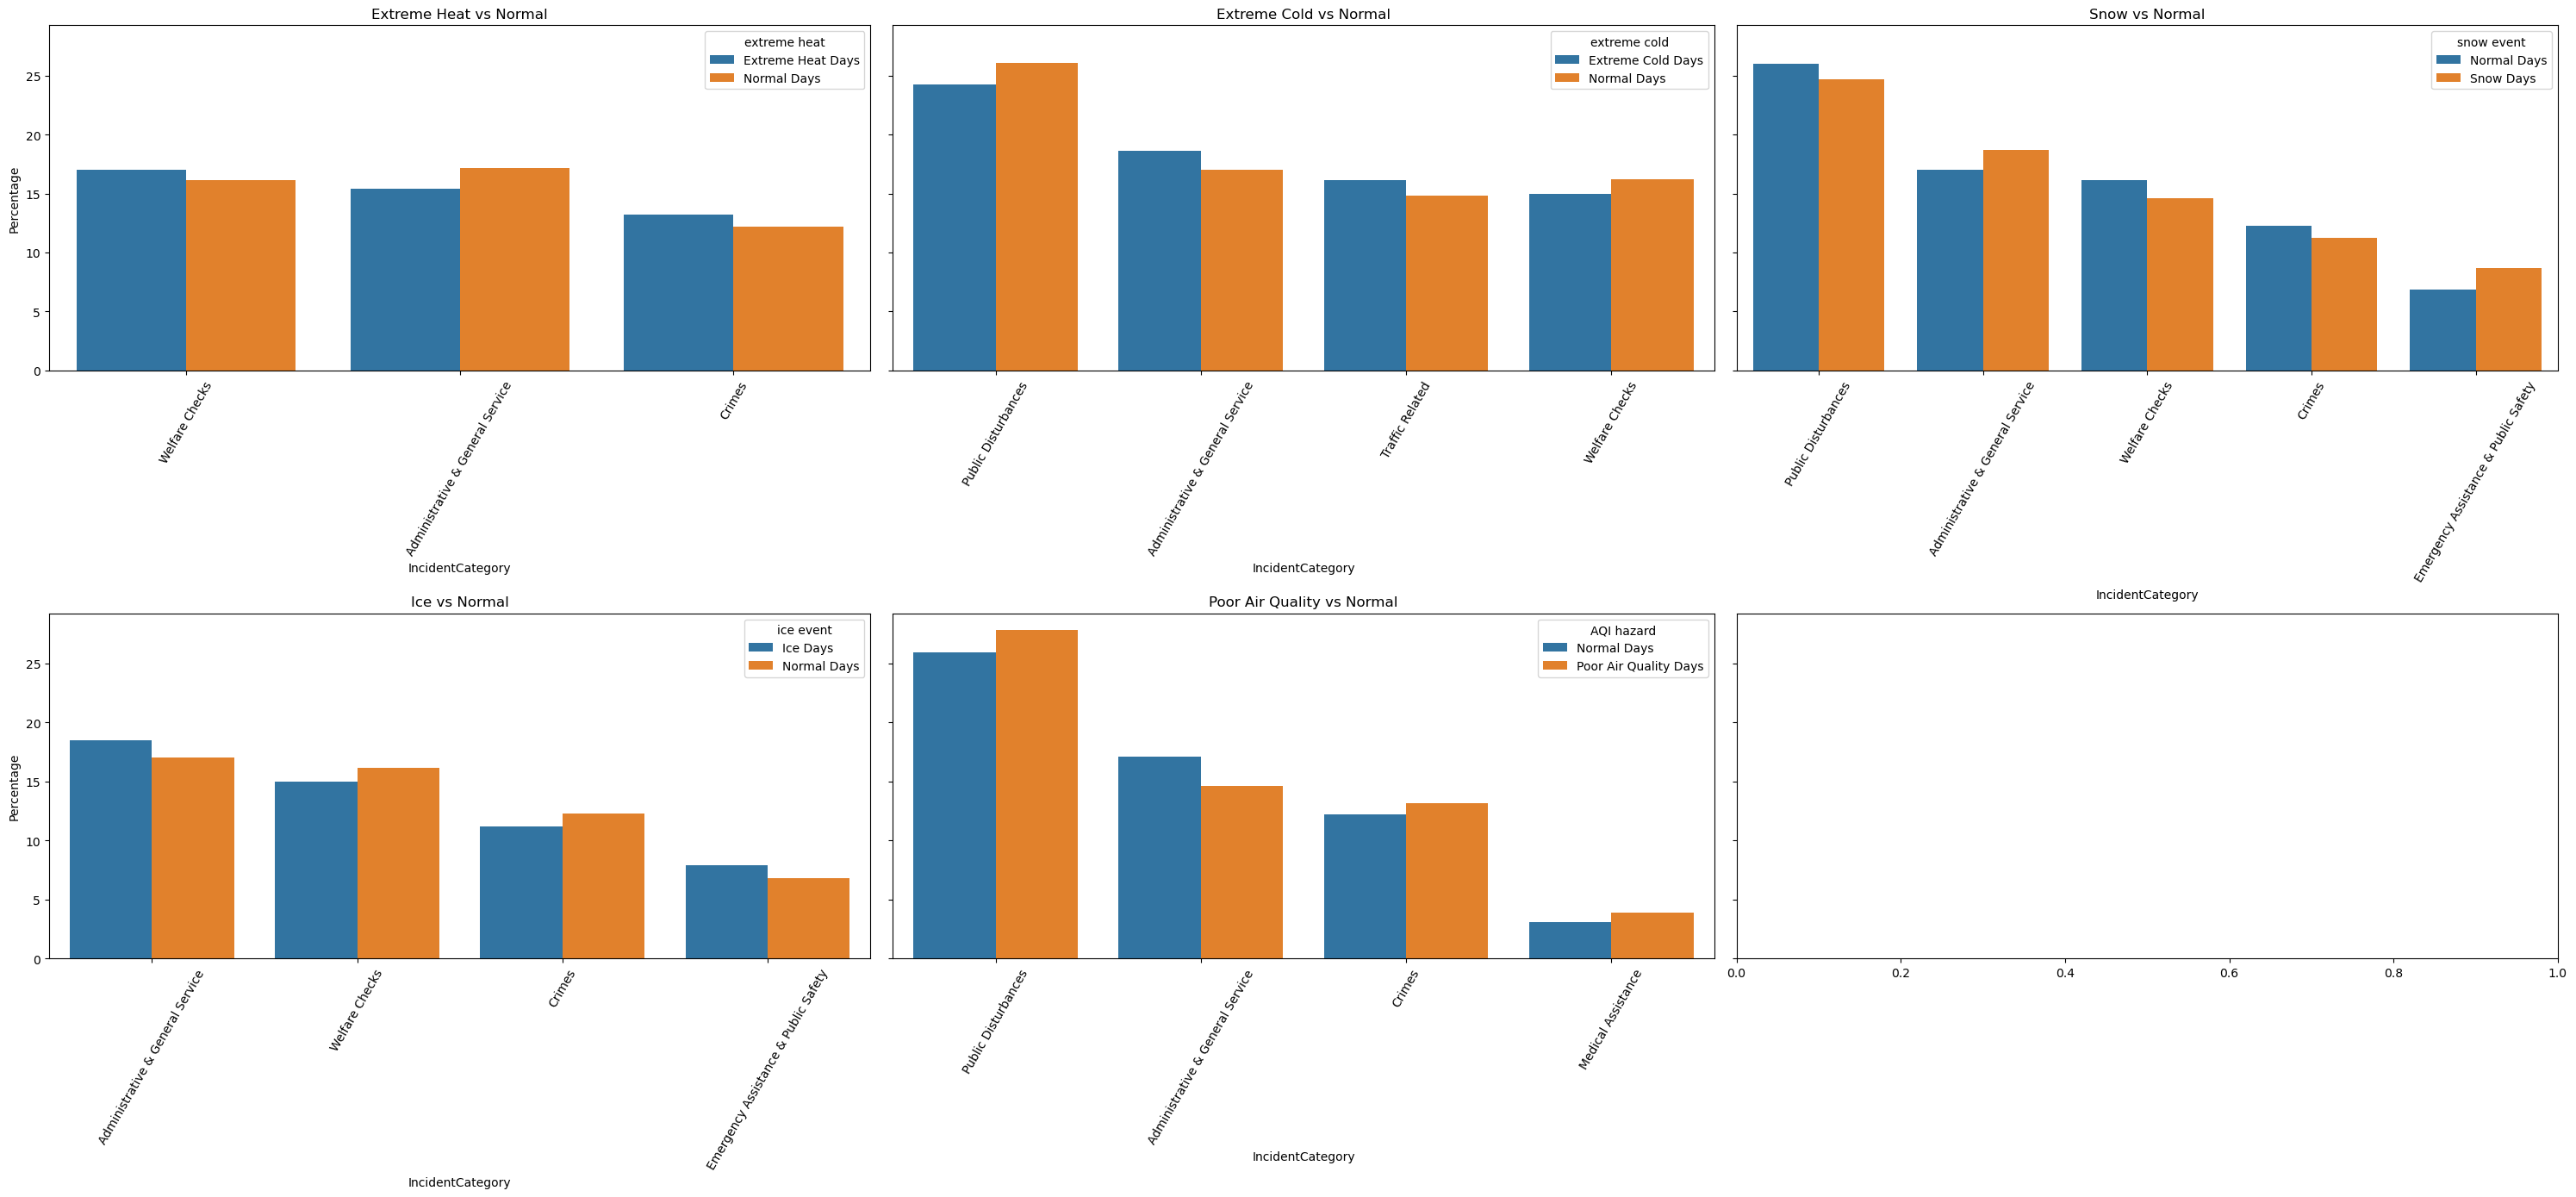

In [348]:
# VISUALIZE call type distributions across different environmental events (from EDA)
# see the change in call type proportions during normal vs. extreme days
def plot_multiple_call_distributions(data, conditions, condition_names, threshold=0.8):
    '''
    Plots call type distributions for normal vs. extreme days for several environmental variables

    data: dataframe to reference (clean_data)
    conditions: the list of environmental conditions, i.e. extreme heat
    condition_names: names of those same conditions for nicer-looking plot titles
    threshold: only plot the call types with a large enough % difference between extreme and non-extreme days
    '''
    
    num_plots = len(conditions)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols  # round up for incomplete row

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 7 * num_rows), sharey=True)
    axes = axes.flatten()  # Flatten in case of multiple rows
    
    for i, (cond, cond_name) in enumerate(zip(conditions, condition_names)):
        temp = data[[cond, 'IncidentCategory']].copy()
        temp[cond] = temp[cond].map({0: 'Normal Days', 1: f'{cond_name} Days'}) # for plot readability

        # Get % distribution of call types (proportion -> percentage)
        distribution = (
            temp.groupby(cond)['IncidentCategory'].value_counts(normalize=True).rename('Percentage').mul(100).reset_index()
        )

        # Pivot to compare % change from normal to extreme days
        # (table with categories as rows, and one column for each day type)
        wide = distribution.pivot(index='IncidentCategory', columns=cond, values='Percentage')
        wide['Diff'] = wide[f'{cond_name} Days'] - wide['Normal Days']

        # Filter for only calltypes with more than a certain % difference
        filtered = wide[wide['Diff'].abs() > threshold].reset_index()
        distribution = distribution[distribution['IncidentCategory'].isin(filtered['IncidentCategory'])]

        # Plot
        sns.barplot(data=distribution, x='IncidentCategory', y='Percentage', hue=cond, ax=axes[i])
        axes[i].set_title(f'{cond_name} vs Normal')
        axes[i].tick_params(axis='x', rotation=60)

    plt.tight_layout()
    plt.show()


# plot them!
plot_multiple_call_distributions(clean_data, 
    ['extreme heat', 'extreme cold', 'snow event', 'ice event', 'AQI hazard'],
    ['Extreme Heat', 'Extreme Cold', 'Snow', 'Ice', 'Poor Air Quality']
)

### 2.2.1: findings from visualizations:
These plots show call types that change by >0.8% during each extreme environmental event.

Call types that notably INCREASED:
- During extreme heat: Welfare checks, crimes
- During extreme cold: Administrative & General Services, traffic related
- During snow: Administrative & General Services, emergency assistance & public safety
- During ice: Administrative & General Services, emergency assistance & public safety
- During poor air quality: Public disturbances, crimes, medical assistance

Call types that notably DECREASED:
- During extreme heat: Administrative & general services
- During extreme cold: Public disturbances, welfare checks
- During snow: Public disturbances, welfare checks, crimes
- During ice: welfare checks, crimes
- During poor air quality: Administrative & General Services

### 2.3 Using A **z-test for proportions**, to test whether the proportion (percentage) of certain call type categories differs significantly between two groups: extreme weather days and normal days.
- a Z-test is a statistical test for comparing the proportions from two populations, to see if the difference between them is statistically significant
- For example, "Is the proportion of welfare check calls significantly higher during extreme heat? Can this be attributed to random chance?"
- A Z-test assumes independent, categorical observations across two groups (certain, specified
   call type versus all others)

In [227]:
def test_call_type_proportions(data, call_type, env_condition_col, alpha=0.05):
    """
    Run z-test to see if the proportion of a specific call type changes during an environmental event
    
    data: clean_data with 'IncidentCategory' and environmental condition cols
    call_type: call type to test
    env_condition_col: environmental condition column name
    alpha: significance level (p-value cutoff 0.05)
    
    Return dict with stats: counts, proportions, p-value, and significance
    """
    # Make sure call_type exists
    if call_type not in data['IncidentCategory'].unique():
        raise ValueError(f"Call type '{call_type}' not found in data.")
    
    # filter for extreme days vs normal days
    extreme = data[data[env_condition_col] == 1]
    normal = data[data[env_condition_col] == 0]
    
    # Counts of the specific call type
    extreme_count = (extreme['IncidentCategory'] == call_type).sum()
    normal_count = (normal['IncidentCategory'] == call_type).sum()
    
    # Total calls (for calculating proportion)
    extreme_total = len(extreme)
    normal_total = len(normal)
    
    # proportions
    extreme_prop = extreme_count / extreme_total
    normal_prop = normal_count / normal_total
    
    # Z-test
    count = np.array([extreme_count, normal_count])
    nobs = np.array([extreme_total, normal_total])
    stat, p_value = proportions_ztest(count, nobs)
    
    # % change
    pct_change = ((extreme_prop / normal_prop) - 1) * 100 if normal_prop > 0 else np.nan
    
    return {
        'call_type': call_type,
        'env_condition': env_condition_col,
        'extreme_proportion': extreme_prop,
        'normal_proportion': normal_prop,
        'extreme_count': extreme_count,
        'normal_count': normal_count,
        'extreme_total': extreme_total,
        'normal_total': normal_total,
        'p_value': p_value,
        'significant': p_value < alpha,
        'pct_change': pct_change
    }


In [228]:
# testing specific relationships:

# Call types that notably INCREASED:
print(f'{test_call_type_proportions(clean_data, 'Welfare Checks', 'extreme heat')}\n')
print(f'{test_call_type_proportions(clean_data, 'Crimes', 'extreme heat')}\n')


print(f'{test_call_type_proportions(clean_data, 'Administrative & General Service', 'extreme cold')}\n')
print(f'{test_call_type_proportions(clean_data, 'Traffic Related', 'extreme cold')}\n')

print(f'{test_call_type_proportions(clean_data, 'Administrative & General Service', 'snow event')}\n')
print(f'{test_call_type_proportions(clean_data, 'Emergency Assistance & Public Safety', 'snow event')}\n')

print(f'{test_call_type_proportions(clean_data, 'Administrative & General Service', 'ice event')}\n')
print(f'{test_call_type_proportions(clean_data, 'Emergency Assistance & Public Safety', 'ice event')}\n')

print(f'{test_call_type_proportions(clean_data, 'Public Disturbances', 'AQI hazard')}\n')
print(f'{test_call_type_proportions(clean_data, 'Crimes', 'AQI hazard')}\n')
print(f'{test_call_type_proportions(clean_data, 'Medical Assistance', 'AQI hazard')}\n')


# Call types that notably DECREASED:
# - During extreme heat: Administrative & general services
# - During extreme cold: Public disturbances, welfare checks
# - During snow: Public disturbances, welfare checks, crimes
# - During ice: welfare checks, crimes
# - During poor air quality: Administrative & General Services

{'call_type': 'Welfare Checks', 'env_condition': 'extreme heat', 'extreme_proportion': 0.17030493017953832, 'normal_proportion': 0.16098977013941046, 'extreme_count': 8964, 'normal_count': 160331, 'extreme_total': 52635, 'normal_total': 995908, 'p_value': 1.5095766994803936e-08, 'significant': True, 'pct_change': 5.786181340628871}

{'call_type': 'Crimes', 'env_condition': 'extreme heat', 'extreme_proportion': 0.13206041607295527, 'normal_proportion': 0.12179137028721529, 'extreme_count': 6951, 'normal_count': 121293, 'extreme_total': 52635, 'normal_total': 995908, 'p_value': 2.419428568070369e-12, 'significant': True, 'pct_change': 8.431669470113468}

{'call_type': 'Administrative & General Service', 'env_condition': 'extreme cold', 'extreme_proportion': 0.18617614269788182, 'normal_proportion': 0.1698127459264459, 'extreme_count': 10354, 'normal_count': 168612, 'extreme_total': 55614, 'normal_total': 992929, 'p_value': 1.8440863766371312e-23, 'significant': True, 'pct_change': 9.6361

In [229]:
# make a function to more readably display results:
# i.e. in this kind of format:

# Call type changes during Extreme Heat days:
#   Animal Issues: 62.1% increase (9.7 to 15.8 calls/day)
#   Medical Assistance: 21.7% increase (3.9 to 4.8 calls/day)
#   Welfare Checks: 19.5% increase (39.6 to 47.4 calls/day)

### 2.4 Categorical Analysis Results:
A Chi-Square Test of Independence was conducted to determine whether the distribution of call categories differed between normal days and extreme environmental conditions. Results showed statistically significant _differences in call type distributions_ for extreme heat, extreme cold, snow, and poor air quality (p < 0.001 for all). This suggests that certain types of calls become more or less frequent during these environmental extremes, not due to random chance.

Afterwards I created visualizations and used statistical tests to identify proportions of specific call types that increased or decreased significantly during extreme days (listed in results above.)

## 3. Examining case studies of the most extreme environmental events:

By printing descriptive statistics to get a comprehensive overview of how crisis calls (volume & types) changed during these events

In [352]:
# the most extreme events in the data:
extreme_heat_event = daily.sort_values('tempmax', ascending=False).reset_index().iloc[0,:]
extreme_cold_event = daily.sort_values('tempmin').reset_index().iloc[0,:]
extreme_snow_event = daily.sort_values('snow', ascending=False).reset_index().iloc[0,:]
extreme_aqi_event = daily.sort_values('AQI', ascending=False).reset_index().iloc[0,:]

heat_date = extreme_heat_event.loc['Date']
cold_date = extreme_cold_event.loc['Date']
snow_date = extreme_snow_event.loc['Date']
aqi_date = extreme_aqi_event.loc['Date']


# Analyze specific case studies
def analyze_specific_event(event_date, days_before=7, days_after=7, event_name="Event"):
    # Get time periods
    before_start = event_date - pd.Timedelta(days=days_before)
    after_end = event_date + pd.Timedelta(days=days_after)
    before_period = daily[(daily['Date'] >= before_start) & (daily['Date'] < event_date)]
    during_period = daily[daily['Date'] == event_date]
    after_period = daily[(daily['Date'] > event_date) & (daily['Date'] <= after_end)]
    
    # Calculate stats of daily calls before/during/after
    before_avg = before_period['daily calls'].mean()
    during_avg = during_period['daily calls'].iloc[0]
    after_avg = after_period['daily calls'].mean()
    pct_change = ((during_avg-before_avg)/before_avg)*100
    
    # Print results
    print(f"\n{event_name} on {event_date.date()}:")
    print(f"  Environmental conditions: Max Temp: {during_period['tempmax'].iloc[0]:.1f}, " 
          f"Min Temp: {during_period['tempmin'].iloc[0]:.1f}, "
          f"Snow: {during_period['snow'].iloc[0]:.1f}, "
          f"AQI: {during_period['AQI'].iloc[0]:.1f}")
    print(f"  Before ({days_before} days): {before_avg:.1f} calls/day")
    print(f"  During event: {during_avg:.1f} calls")
    print(f"  After ({days_after} days): {after_avg:.1f} calls/day")
    print(f"  % Change from before to during: {pct_change:.1f}%")
    
    # Return periods & summary data
    return before_period, during_period, after_period, {
        'event_name': event_name,
        'change_pct': pct_change,
        'during_calls': during_avg}


# CALL TYPES changes during extreme conditions
def analyze_call_type_changes(condition_col, condition_name):
    # Group by date and call type
    call_counts = clean_data.groupby(['Date', 'IncidentCategory']).size().reset_index(name='count')
    
    # normal vs. extreme days
    normal_days = call_counts.merge(daily[daily[condition_col] == 0][['Date']], on='Date')
    extreme_days = call_counts.merge(daily[daily[condition_col] == 1][['Date']], on='Date')
    # Calculate averages
    normal_avg = normal_days.groupby('IncidentCategory')['count'].mean()
    extreme_avg = extreme_days.groupby('IncidentCategory')['count'].mean()
    
    # Calculate changes
    results = pd.DataFrame({'normal_avg': normal_avg, 'extreme_avg': extreme_avg})
    results['diff'] = results['extreme_avg'] - results['normal_avg']
    results['pct_change'] = (results['diff'] / results['normal_avg']) * 100
    results = results.sort_values('pct_change', ascending=False)
    
    print(f"\nCall type changes during {condition_name} days:")
    for call_type, row in results.head(3).iterrows():
        direction = "increase" if row['diff'] > 0 else "decrease"
        print(f"  {call_type}: {abs(row['pct_change']):.1f}% {direction} " 
              f"({row['normal_avg']:.1f} to {row['extreme_avg']:.1f} calls/day)")
    
    return results



# analysis for specific extreme events
print("\n CASE STUDIES: MOST EXTREME EVENTS")
_, _, _, heat_summary = analyze_specific_event(heat_date, event_name="Extreme Heat")
_, _, _, cold_summary = analyze_specific_event(cold_date, event_name="Extreme Cold")
_, _, _, snow_summary = analyze_specific_event(snow_date, event_name="Snow Event")
_, _, _, aqi_summary = analyze_specific_event(aqi_date, event_name="Poor Air Quality")

# # Run analyses for all extreme vs normal days
# print("\n AGGREGATE ANALYSIS: ALL EXTREME VS NORMAL DAYS")
# heat_changes = analyze_call_type_changes('extreme heat', 'Extreme Heat')
# cold_changes = analyze_call_type_changes('extreme cold', 'Extreme Cold')
# snow_changes = analyze_call_type_changes('snow event', 'Snow')
# aqi_changes = analyze_call_type_changes('AQI hazard', 'Poor Air Quality')

# # summary
# print("\n SUMMARY")
# events = [heat_summary, cold_summary, snow_summary, aqi_summary]
# max_impact = max(events, key=lambda x: abs(x['change_pct']))
# print(f"• Largest impact: {max_impact['event_name']} ({max_impact['change_pct']:.1f}% change in calls)")

# # Find MOST CONSISTNETLY AFFECTED CALL TYPES
# top_heat = set(heat_changes.head(2).index)
# top_cold = set(cold_changes.head(2).index)
# top_snow = set(snow_changes.head(2).index)
# top_aqi = set(aqi_changes.head(2).index)

# common_increases = set.intersection(top_heat, top_cold, top_snow, top_aqi)
# if common_increases:
#     print(f"• Call types that increase during all extreme events: {', '.join(common_increases)}")

# print("\n• Impact by event type:")
# for event in events:
#     print(f"  - {event['event_name']}: {event['change_pct']:.1f}% change in call volume")


 CASE STUDIES: MOST EXTREME EVENTS

Extreme Heat on 2021-06-27:
  Environmental conditions: Max Temp: 110.8, Min Temp: 67.9, Snow: 0.0, AQI: 74.0
  Before (7 days): 647.9 calls/day
  During event: 566.0 calls
  After (7 days): 676.7 calls/day
  % Change from before to during: -12.6%

Extreme Cold on 2017-01-06:
  Environmental conditions: Max Temp: 38.8, Min Temp: 13.0, Snow: 0.0, AQI: 84.0
  Before (7 days): 476.0 calls/day
  During event: 537.0 calls
  After (7 days): 482.7 calls/day
  % Change from before to during: 12.8%

Snow Event on 2019-02-25:
  Environmental conditions: Max Temp: 36.0, Min Temp: 33.0, Snow: 4.6, AQI: 56.0
  Before (7 days): 508.7 calls/day
  During event: 689.0 calls
  After (7 days): 511.4 calls/day
  % Change from before to during: 35.4%

Poor Air Quality on 2023-08-15:
  Environmental conditions: Max Temp: 104.9, Min Temp: 67.9, Snow: 0.0, AQI: 211.0
  Before (7 days): 539.9 calls/day
  During event: 497.0 calls
  After (7 days): 507.0 calls/day
  % Change